In [6]:
# ============================================================================
# CELL 5: CARRY SIGNAL - UPDATED FOR NEW DATA STRUCTURE
# ============================================================================
print("\n" + "="*60)
print("CARRY SIGNAL")
print("="*60)

carry_raw = pd.DataFrame(index=prices_clean.index)

# ========================================
# RATES: Rolldown from futures spread
# ========================================
print("\n1. RATES CARRY: Rolldown = (TYc1 - TYc2) / DV01")

if 'TYc1' in prices_clean.columns and 'TYc2' in prices_clean.columns:
    front = prices_clean['TYc1']
    second = prices_clean['TYc2']
    duration = prices_clean['MOD_DURTN']
    
    # Rolldown carry = price spread / DV01
    rolldown_carry = (front - second) / duration
    carry_raw['TYc1'] = rolldown_carry
    
    latest_front = front.iloc[-1]
    latest_second = second.iloc[-1]
    latest_spread = latest_front - latest_second
    latest_carry = rolldown_carry.iloc[-1]
    
    print(f"   TYc1 (10Y Front): {latest_front:.3f}")
    print(f"   TYc2 (10Y 2nd): {latest_second:.3f}")
    print(f"   Spread: {latest_spread:.3f}")
    #print(f"   Duration: {duration:.2f}")
    print(f"   Rolldown Carry: {latest_carry:.4f}")
else:
    print("   ! TYc1/TYc2 not available")    

# ========================================
# FX: Interest rate differential
# ========================================
print("\n2. FX CARRY: Interest Rate Differential (Risk-adjusted)")

fx_mappings = {
    'EUR=': ('EUR3MD=', 'USD3MD='),   # EURUSD
    'JPY=': ('USD3MD=', 'JPY3MD='),   # USDJPY
    'AUD=': ('AUD3MD=', 'USD3MD='),   # AUDUSD
}

print("\n2. FX CARRY: Interest Rate Differential (Risk-adjusted)")

for fx, (base_rate, quote_rate) in fx_mappings.items():

    if fx not in prices_clean.columns:
        print(f"   {fx}: FX price missing")
        continue

    if base_rate not in prices_clean.columns or quote_rate not in prices_clean.columns:
        print(f"   {fx}: Rate data missing")
        continue

    fx_ret = prices_clean[fx].pct_change()
    fx_vol = fx_ret.rolling(63).std() * np.sqrt(252)

    rate_diff = prices_clean[base_rate] - prices_clean[quote_rate]
    carry_raw[fx] = rate_diff / (fx_vol + 1e-6)

    print(f"   {fx}: {base_rate} - {quote_rate} = {rate_diff.iloc[-1]:.2f}")


# ========================================
# EQUITIES: Dividend yield from SPX/SPXTR
# ========================================
print("\n3. EQUITY CARRY: Dividend Yield")
div_carry = prices['SPX_div_carry']
# Apply to .SPX in our prices
if '.SPX' in prices_clean.columns:
    # Align the series
    aligned_carry = div_carry.reindex(prices_clean.index).fillna(method='ffill')
    carry_raw['.SPX'] = aligned_carry
    
    latest = aligned_carry.dropna().iloc[-1] if not aligned_carry.dropna().empty else 0
    print(f"   .SPX: Dividend Yield = {latest:.2f}%")


else:
    print("   ! No dividend data available")


# ========================================
# COMMODITIES: Roll yield (price-based proxy)
# ========================================

print("\n4. COMMODITY CARRY: Roll Yield (c1 vs c2)")

commodities = ['CL', 'GC']  # add more tickers if needed

for comm in commodities:
    c1 = f'{comm}c1'
    c2 = f'{comm}c2'
    
    if c1 in prices_clean.columns and c2 in prices_clean.columns:
        # Roll yield = (front - second) / front
        rolldown_carry = (prices_clean[c1] - prices_clean[c2]) / prices_clean[c1]
        carry_raw[c1] = rolldown_carry
        latest = rolldown_carry.iloc[-1]
        
        print(f"   {c1}: Roll yield = {latest:.4f} (pos=backwardation, neg=contango)")

    else:
        print(f"   {comm}: Missing c1 or c2 data")
   
   
# Fill NaNs if needed
carry_raw = carry_raw.fillna(method='ffill').fillna(0)

# Check valid carry
valid_carry = carry_raw.abs().sum().sum()
if valid_carry == 0:
    print("\n   ! WARNING: All carry signals are zero")
else:
    print(f"\n✓ Carry signal calculated (total abs carry: {valid_carry:.2f})")

carry_zscore = carry_raw.apply(lambda x: (x - x.mean()) / (x.std() + 1e-6), axis=1) 
print(f"\n✓ Carry signals normalized (z-score)")


CARRY SIGNAL

1. RATES CARRY: Rolldown = (TYc1 - TYc2) / DV01
   TYc1 (10Y Front): 108.766
   TYc2 (10Y 2nd): 108.688
   Spread: 0.078
   Rolldown Carry: 0.0099

2. FX CARRY: Interest Rate Differential (Risk-adjusted)

2. FX CARRY: Interest Rate Differential (Risk-adjusted)
   EUR=: EUR3MD= - USD3MD= = -1.60
   JPY=: USD3MD= - JPY3MD= = 4.28
   AUD=: AUD3MD= - USD3MD= = -0.21

3. EQUITY CARRY: Dividend Yield
   .SPX: Dividend Yield = 1.32%

4. COMMODITY CARRY: Roll Yield (c1 vs c2)
   CLc1: Roll yield = 0.0065 (pos=backwardation, neg=contango)
   GCc1: Roll yield = -0.0045 (pos=backwardation, neg=contango)

✓ Carry signal calculated (total abs carry: 92866.24)

✓ Carry signals normalized (z-score)


In [2]:


# plt.figure(figsize=(14, 8))
# for column in carry_zscore.columns:
#     plt.plot(carry_zscore.index, carry_zscore[column], label=column, linewidth=2)

# #plt.plot(prices_clean.index, prices_clean["CLc1"], label="Gold", linewidth=2)


# plt.title('Carry signal', fontsize=14, fontweight='bold')
# plt.xlabel('Date')
# plt.ylabel('Carry')
# plt.legend(loc='best')
# plt.grid(True, alpha=0.3)
# plt.tight_layout()
# plt.show()

In [9]:
# ============================================================================
# CELL 6: MOMENTUM SIGNAL (RAW + NORMALIZED)
# ============================================================================
print("\n" + "="*60)
print("MOMENTUM SIGNAL (RAW + NORMALIZED)")
print("="*60)

# Multi-period momentum: 3M, 6M, 12M
lookbacks = [63, 126, 252]        # trading days
weights = [0.5, 0.3, 0.2]         # more weight on recent momentum

# Only use columns that exist in carry_raw
relevant_cols = carry_raw.columns.tolist()

# Initialize score with float zeros
momentum_score = pd.DataFrame(0.0, index=prices_clean.index, columns=relevant_cols)

# Calculate weighted multi-period momentum for relevant columns
for lb, w in zip(lookbacks, weights):
    lb_ret = prices_clean[relevant_cols].pct_change(lb)
    momentum_score += lb_ret * w

# Fill initial NaNs (due to lookbacks)
momentum_score = momentum_score.fillna(0.0)


def winsorize_cs(row, lower=0.05, upper=0.95):
    lo = row.quantile(lower)
    hi = row.quantile(upper)
    return row.clip(lo, hi)

momentum_winsor = momentum_score.apply(winsorize_cs, axis=1)

# --- Print latest raw momentum (percent) ---
print(f"\nLatest raw momentum:")
latest_raw = momentum_winsor.iloc[-1]
for ticker, val in latest_raw.items():
    print(f"  {ticker:12s}: {val*100:>6.2f}%")

# --- Cross-sectional z-score normalization for each day ---
momentum_zscore = momentum_winsor.apply(lambda x: (x - x.mean()) / (x.std() + 1e-6), axis=1)

print(f"\n✓ Continuous momentum calculated and normalized (z-score)")

# --- Display latest normalized momentum ---
print(f"\nLatest normalized momentum (z-score):")
latest_norm = momentum_zscore.iloc[-1]
for ticker, val in latest_norm.items():
    status = "POSITIVE" if val > 0 else "NEGATIVE"
    print(f"  {ticker:12s}: {status:8s} ({val:>6.2f})")



MOMENTUM SIGNAL (RAW + NORMALIZED)

Latest raw momentum:
  TYc1        :  -3.44%
  EUR=        :  -5.46%
  JPY=        :   4.51%
  AUD=        :  -7.73%
  .SPX        :   7.85%
  CLc1        :  -5.27%
  GCc1        :   8.51%

✓ Continuous momentum calculated and normalized (z-score)

Latest normalized momentum (z-score):
  TYc1        : NEGATIVE ( -0.48)
  EUR=        : NEGATIVE ( -0.77)
  JPY=        : POSITIVE (  0.68)
  AUD=        : NEGATIVE ( -1.10)
  .SPX        : POSITIVE (  1.16)
  CLc1        : NEGATIVE ( -0.75)
  GCc1        : POSITIVE (  1.26)


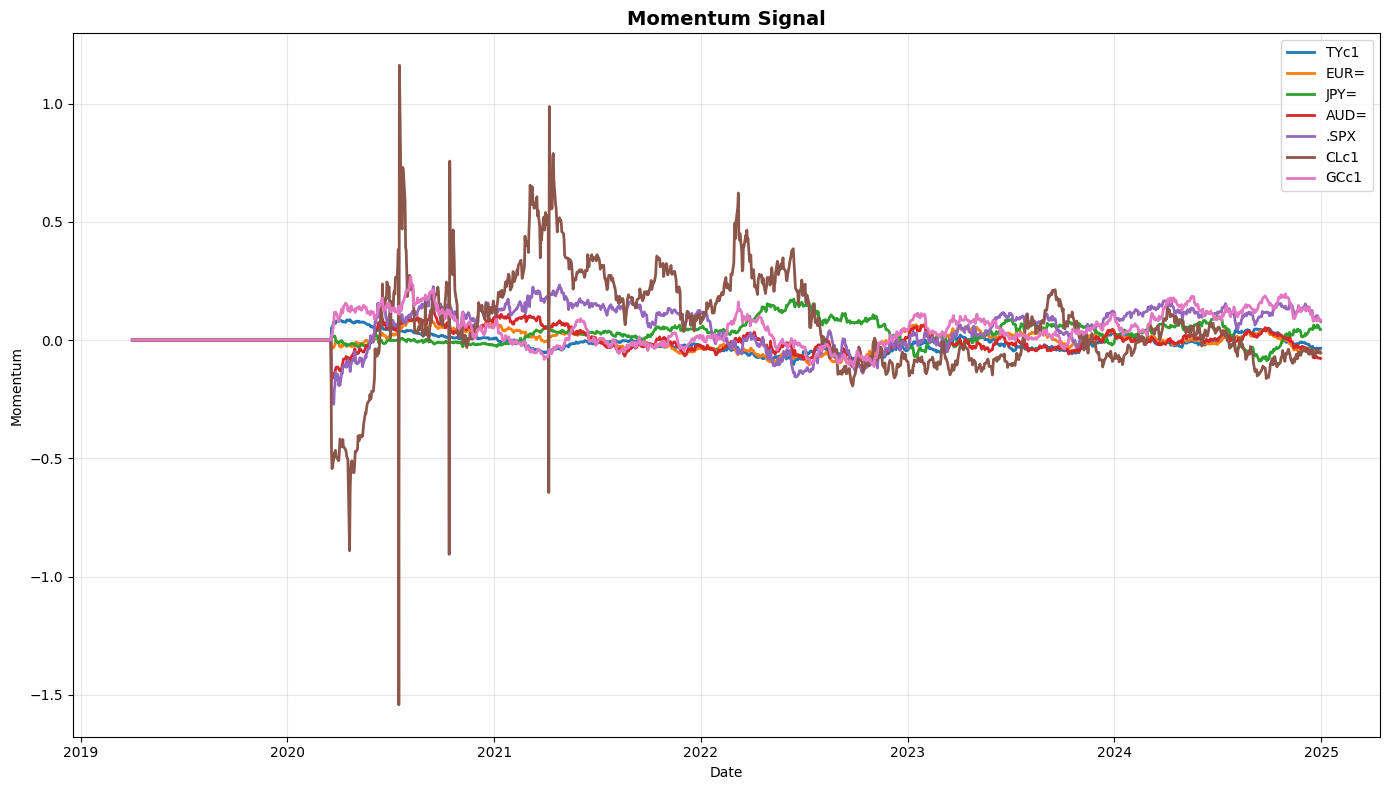

In [10]:
plt.figure(figsize=(14, 8))
for column in momentum_winsor.columns:
    plt.plot(momentum_winsor.index, momentum_winsor[column], label=column, linewidth=2)

#plt.plot(prices_clean.index, prices_clean["CLc1"], label="Gold", linewidth=2)


plt.title('Momentum Signal', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Momentum')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



In [11]:
# ============================================================================
# CELL 7: VOLATILITY SIGNAL
# ============================================================================
print("\n" + "="*60)
print("VOLATILITY SIGNAL")
print("="*60)


# Realized volatility
vol_lookback = 60  # 60D rolling vol
realized_vol = returns[relevant_cols].rolling(vol_lookback).std() * np.sqrt(252)

# Volatility signal: Inverse vol (lower vol = higher score)
# This is for RANKING assets, not just scaling
vol_score = 1 / (realized_vol + 1e-6)

# Z-score normalization
volatility_zscore = vol_score.apply(lambda x: (x - x.mean()) / (x.std() + 1e-6), axis=1)

print(f"✓ Volatility signal calculated")
print(f"\nLatest volatility (lower vol = higher score):")
for ticker in volatility_zscore.columns:
    zscore = volatility_zscore.loc[volatility_zscore.index[-1], ticker]
    vol = realized_vol.loc[realized_vol.index[-1], ticker]
    print(f"  {ticker:12s}: Vol={vol*100:>5.1f}%  z-score={zscore:>6.2f}")



VOLATILITY SIGNAL
✓ Volatility signal calculated

Latest volatility (lower vol = higher score):
  TYc1        : Vol=  5.2%  z-score=  1.77
  EUR=        : Vol=  7.5%  z-score=  0.62
  JPY=        : Vol= 10.4%  z-score= -0.11
  AUD=        : Vol=  9.0%  z-score=  0.20
  .SPX        : Vol= 12.4%  z-score= -0.40
  CLc1        : Vol= 28.4%  z-score= -1.29
  GCc1        : Vol= 16.4%  z-score= -0.79
